https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html was used as a reference for this notebook.

In [18]:
%load_ext autoreload
%autoreload 2

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from tqdm import tqdm
from torcheval.metrics import FrechetInceptionDistance

from torch.autograd import Variable
from torch import autograd

# Number of GPUs available
ngpu = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparation

In [19]:
# Root directory for dataset
dataset_name = "celeba"
dataroot = "data/" + dataset_name + "/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

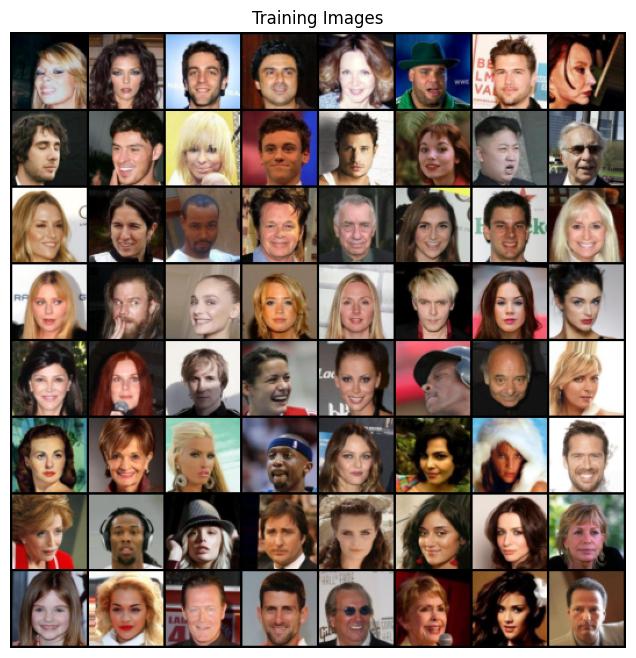

In [20]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = dset.ImageFolder(root=dataroot, transform=transform)

# load CIFAR10 dataset
# trainset = dset.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig('cifar10_training_images.png')
plt.show()

## Wasserstein GANs (WGAN) Model Architecture
https://arxiv.org/pdf/1704.00028

In [21]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [22]:
# Number of channels in the training images
num_channels = 3

# Size of z latent vector
num_z = 100

# Size of feature maps in generator
num_gen_fearute_maps = 64

# Size of feature maps in critic
num_dics_fearute_maps = 64

## Definition of Generator

In [23]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main_module = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( num_z, num_gen_fearute_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_gen_fearute_maps * 8),
            nn.ReLU(True),

            # state size. ``(num_gen_fearute_maps*8) x 4 x 4``
            nn.ConvTranspose2d(num_gen_fearute_maps * 8, num_gen_fearute_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_gen_fearute_maps * 4),
            nn.ReLU(True),

            # state size. ``(num_gen_fearute_maps*4) x 8 x 8``
            nn.ConvTranspose2d( num_gen_fearute_maps * 4, num_gen_fearute_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_gen_fearute_maps * 2),
            nn.ReLU(True),

            # state size. ``(num_gen_fearute_maps*2) x 16 x 16``
            nn.ConvTranspose2d( num_gen_fearute_maps * 2, num_gen_fearute_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_gen_fearute_maps),
            nn.ReLU(True),

            # state size. ``(num_gen_fearute_maps) x 32 x 32``
            nn.ConvTranspose2d( num_gen_fearute_maps, num_channels, 4, 2, 1, bias=True),
        )

        # state size. ``(num_channels) x 64 x 64``
        self.output = nn.Tanh()    

    def forward(self, input):
        x = self.main_module(input)
        return self.output(x)

In [24]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# randomly initialize all weights
netG.apply(weights_init)

print(netG)

Generator(
  (main_module): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (output): Tanh()
)


In [25]:
class Critic(nn.Module):
    def __init__(self, ngpu):
        super(Critic, self).__init__()
        self.ngpu = ngpu
        self.main_module = nn.Sequential(
            # input is ``(num_channels) x 64 x 64``
            nn.Conv2d(num_channels, num_dics_fearute_maps, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(num_dics_fearute_maps, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. ``(num_dics_fearute_maps) x 32 x 32``
            nn.Conv2d(num_dics_fearute_maps, num_dics_fearute_maps * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(num_dics_fearute_maps * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. ``(num_dics_fearute_maps*2) x 16 x 16``
            nn.Conv2d(num_dics_fearute_maps * 2, num_dics_fearute_maps * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(num_dics_fearute_maps * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. ``(num_dics_fearute_maps*4) x 8 x 8``
            nn.Conv2d(num_dics_fearute_maps * 4, num_dics_fearute_maps * 8, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(num_dics_fearute_maps * 8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # state size. ``(num_dics_fearute_maps*8) x 4 x 4``
        self.output = nn.Sequential(
            # The output of D is no longer a probability, we do not apply sigmoid at the output of D.
            nn.Conv2d(num_dics_fearute_maps * 8, 1, 4, 1, 0, bias=True),
        )

    def forward(self, input):
        x = self.main_module(input)
        return self.output(x)

In [26]:
# Create the critic
netD = Critic(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Critic(
  (main_module): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (output): Sequen

## Training of WGAN

Here we use the same hyperparameters as in the original paper: https://arxiv.org/pdf/1704.00028

In [27]:
# Learning rate for optimizers
learning_rate = 1e-4

# Beta hyperparameter for Adam optimizers
b1 = 0.5
b2 = 0.999

In [28]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# batch of latent vectors to visualize the progression of the generator
fixed_noise = torch.randn(64, num_z, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(b1, b2))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(b1, b2))

generator_iters = 6000
critic_iter = 5 # we train the critic multiple times to get better gradients for the generator
lambda_term = 10

In [29]:
# Number of training epochs
num_epochs = 30

In [30]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_wasserstein_losses = []
fid_score = {}
iters = 0

In [31]:
def calculate_gradient_penalty(batch_size, lambda_term, real_images, fake_images):
  eta = torch.FloatTensor(batch_size,1,1,1).uniform_(0,1)
  eta = eta.expand(batch_size, real_images.size(1), real_images.size(2), real_images.size(3)).to(device)

  # this is \hat{x} in the formula
  interpolated = (eta * real_images + ((1 - eta) * fake_images)).to(device)
  interpolated = Variable(interpolated, requires_grad=True)

  prob_interpolated = netD(interpolated)

  # calculate gradients of probabilities with respect to examples
  gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                          grad_outputs=torch.ones(
                              prob_interpolated.size()).to(device),
                          create_graph=True, retain_graph=True)[0]

  # flatten the gradients to it calculates norm batchwise
  gradients = gradients.view(gradients.size(0), -1)
  
  grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_term
  return grad_penalty

In [32]:
one = torch.tensor(1, dtype=torch.float)
minus_one = one * -1

In [33]:
def get_infinite_batches(data_loader):
  while True:
    epochs = 0
    for i, (images, _) in enumerate(data_loader):
        yield images, epochs
    epochs += 1

In [ ]:
print("Starting Training Loop...")
# For each epoch

# Now batches are callable self.data.next()
data = get_infinite_batches(dataloader)

last_epoch = 0

for g_iter in tqdm(range(generator_iters)):
    for p in netD.parameters():
        p.requires_grad = True

    ############################
    # (1) Update D network
    ###########################
    ## Train with all-real batch
    for d_iter in range(critic_iter):
        netD.zero_grad()

        # Format batch
        real_cpu, epoch = data.__next__()
        real_cpu = real_cpu.to(device)

        # handle end of epoch
        b_size = real_cpu.size(0)
        if b_size != batch_size:
            continue

        # Train with real images
        lossD_real = netD(real_cpu)
        lossD_real = lossD_real.mean()
        lossD_real.backward(minus_one)

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noises = torch.randn(b_size, num_z, 1, 1, device=device)
        # Generate fake image batch with G
        fake_images = netG(noises)

        lossD_fake = netD(fake_images.detach())
        lossD_fake = lossD_fake.mean()
        lossD_fake.backward(one)

        # Train with gradient penalty
        gradient_penalty = calculate_gradient_penalty(batch_size, lambda_term, real_cpu, fake_images)
        gradient_penalty.backward()
        
        # Compute error of D as sum over the fake and the real batches
        lossD = lossD_fake - lossD_real + gradient_penalty
        wassersteinD = lossD_real - lossD_fake

        # Update D
        optimizerD.step()

    ############################
    # (2) Update G network
    ###########################
    # Generator update
    for p in netD.parameters():
        p.requires_grad = False  # to avoid computation
        
    netG.zero_grad()
    # Since we just updated D, perform another forward pass of all-fake batch through D
    lossG = netD(fake_images)
    print(lossG)
    lossG = lossG.mean()
    lossG.backward(minus_one)

    # Update G
    optimizerG.step()

    # Output training stats
    if g_iter % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f \tWasserstein_D: %.4f'
                % (epoch, num_epochs, g_iter, len(dataloader),
                    lossD.item(), lossG.item(), wassersteinD.item()))

    # Save Losses for plotting later
    G_losses.append(lossG.item())
    D_losses.append(lossD.item())
    D_wasserstein_losses.append(wassersteinD.item())

    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    # every 10 epochs calculate FIDand save the model
    if iters % 1000 == 0:
        print(f'Calculating FID for epoch {epoch}')

        # calculate FID
        fid = FrechetInceptionDistance()

        # generate 10000 images
        fake_images = []
        for i in range(10000 // batch_size):
            noise = torch.randn(1, num_z, 1, 1, device=device)
            fake_images.append(netG(noise).detach().cpu())
        fake_images = torch.cat(fake_images, dim=0)

        # real images
        real_images = next(iter(dataloader))[0][:10000].to(device)

        # When default inception-v3 model is used, images are expected to be in the [0, 1] interval
        real_images = (real_images + 1) / 2
        fake_images = (fake_images + 1) / 2

        fid.update(real_images, True)
        fid.update(fake_images, False)

        fid_score[iters] = fid.compute().item()

        # save model
        torch.save(netG.state_dict(), f'./models/wgan/{dataset_name}/netG_{iters}.pth')
        torch.save(netD.state_dict(), f'./models/wgan/{dataset_name}/netD_{iters}.pth')

        state = {
            'epochs': epoch,
            'iters': iters,
            'G_losses': G_losses,
            'D_losses': D_losses,
            'D_wasserstein_losses': D_wasserstein_losses,
            'img_list': img_list,
            'fid_score': fid_score
        }

        torch.save(state, f'./models/wgan/{dataset_name}/state_{iters}.pth')

    iters += 1

## Loading a trained model

In [34]:
# load the trained model
netG.load_state_dict(torch.load(f'models/wgan/{dataset_name}/netG_34000.pth'))
netD.load_state_dict(torch.load(f'models/wgan/{dataset_name}/netD_34000.pth'))

# load state
state = torch.load(f'models/wgan/{dataset_name}/state_34000.pth')
epochs = state['epochs']
iters = state['iters']
G_losses = state['G_losses']
D_losses = state['D_losses']
D_wasserstein_losses = state['D_wasserstein_losses']
img_list = state['img_list']
fid_score = state['fid_score']

## Generate random new images

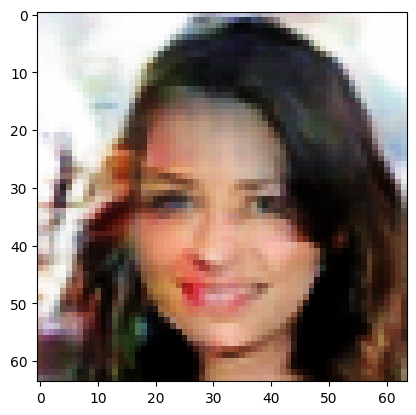

In [100]:
fixed_noise2 = torch.randn(1, num_z, 1, 1, device=device)
# Generate fake image batch with G
with torch.no_grad():
    fake = netG(fixed_noise2).detach().cpu()
img = vutils.make_grid(fake, padding=2, normalize=True)
plt.imshow(np.transpose(img,(1,2,0)), animated=True)

## Perform Vector Arithmetic on Generated Images
first generate new images in the upper code cell, then store sutable images in the lower code cell to temporally store the images for vector arithmetic.

In [ ]:
fake0 = fake

In [ ]:
fake1 = fake

In [ ]:
fake2 = fake

In [ ]:
img = vutils.make_grid(fake0, padding=2, normalize=True)
plt.imshow(np.transpose(img,(1,2,0)), animated=True)

In [ ]:
img = vutils.make_grid(fake1, padding=2, normalize=True)
plt.imshow(np.transpose(img,(1,2,0)), animated=True)

In [ ]:
img = vutils.make_grid(fake2, padding=2, normalize=True)
plt.imshow(np.transpose(img,(1,2,0)), animated=True)

In [ ]:
new_person = fake0 - fake1 + fake2

In [ ]:
img = vutils.make_grid(new_person, padding=2, normalize=True)
plt.imshow(np.transpose(img,(1,2,0)), animated=True)

## Plot the Wasserstein Distances of the Critic

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


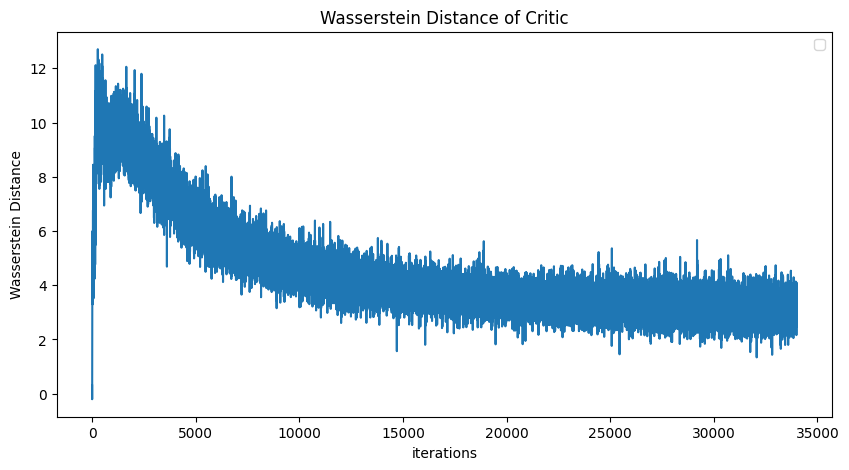

In [101]:
plt.figure(figsize=(10,5))
plt.title("Wasserstein Distance of Critic")
plt.plot(D_wasserstein_losses)
plt.xlabel("iterations")
plt.ylabel("Wasserstein Distance")
plt.legend()
plt.savefig('wgan_loss.png')
plt.show()

## Analyze the generated images

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

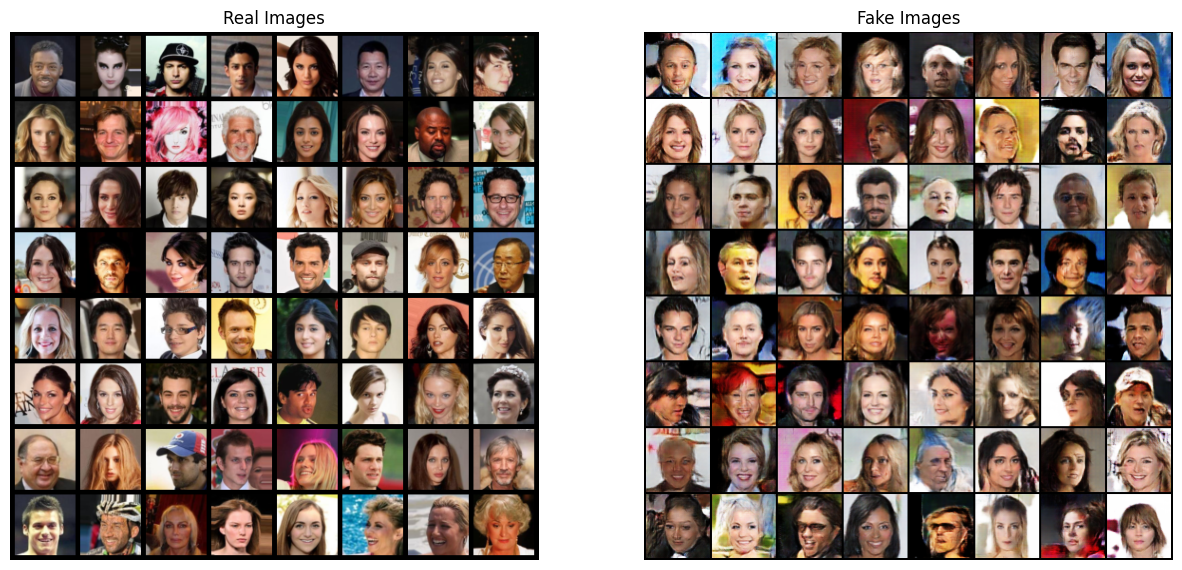

In [102]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()